<a href="https://colab.research.google.com/github/InesFaria-UM/DataScience4Covid19/blob/main/DL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

For this workflow it will be necessary import the following packages:

In [50]:
import os
from google.colab import drive
import pandas as pd
import numpy as np
import matplotlib as plt
import keras
from tensorflow.keras import layers, callbacks
from keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D
from keras.layers import Flatten
from keras.layers import Dense
from keras import regularizers
from keras.layers import Dropout
from keras.layers.normalization import BatchNormalization
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras import backend as K
from tensorflow.keras.layers import InputLayer
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from mlxtend.plotting import plot_confusion_matrix

import warnings
warnings.filterwarnings('ignore') 

import matplotlib.pyplot as plt
from matplotlib.image import imread
import cv2

Before starting the development of the predictive models, we proceeded to extract the dataset, directly from Kaggle.

In [3]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"

In [5]:
%cd /content/gdrive/My Drive/Kaggle

/content/gdrive/My Drive/Kaggle


In [ ]:
!kaggle datasets download -d darshan1504/covid19-detection-xray-dataset

 90% 168M/186M [00:01<00:00, 161MB/s]
100% 186M/186M [00:01<00:00, 167MB/s]


In [ ]:
ls

kaggle.json  NonAugmentedTrain/  TrainData/  ValData/


In [ ]:
!unzip \*.zip  && rm *.zip;

Streaming output truncated to the last 5000 lines.
  inflating: NonAugmentedTrain/BacterialPneumonia/164.jpeg  
  inflating: NonAugmentedTrain/BacterialPneumonia/165.jpeg  
  inflating: NonAugmentedTrain/BacterialPneumonia/166.jpeg  
  inflating: NonAugmentedTrain/BacterialPneumonia/167.jpeg  
  inflating: NonAugmentedTrain/BacterialPneumonia/168.jpeg  
  inflating: NonAugmentedTrain/BacterialPneumonia/169.jpeg  
  inflating: NonAugmentedTrain/BacterialPneumonia/17.jpeg  
  inflating: NonAugmentedTrain/BacterialPneumonia/170.jpeg  
  inflating: NonAugmentedTrain/BacterialPneumonia/171.jpeg  
  inflating: NonAugmentedTrain/BacterialPneumonia/172.jpeg  
  inflating: NonAugmentedTrain/BacterialPneumonia/173.jpeg  
  inflating: NonAugmentedTrain/BacterialPneumonia/174.jpeg  
  inflating: NonAugmentedTrain/BacterialPneumonia/175.jpeg  
  inflating: NonAugmentedTrain/BacterialPneumonia/176.jpeg  
  inflating: NonAugmentedTrain/BacterialPneumonia/177.jpeg  
  inflating: NonAugmentedTrain/Bact

Initially the pixel values of the images that will be used for training and testing were scaled in the range from [0,255] to [0,1] interval. 

In [6]:
train_datagen = ImageDataGenerator(rescale=1./255,shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

In [7]:
test_datagen = ImageDataGenerator(rescale=1./255)

Furtherly, batches of tensor image data are generated with real-time data augmentation

In [8]:
train_generator = train_datagen.flow_from_directory(
        '/content/gdrive/My Drive/Kaggle/TrainData',
        target_size=(384, 384),
        batch_size=32,
        class_mode='categorical')
test_generator = test_datagen.flow_from_directory(
        '/content/gdrive/My Drive/Kaggle/ValData',
        target_size=(384, 384),
        batch_size=32,
        class_mode='categorical')

Found 2023 images belonging to 4 classes.
Found 988 images belonging to 4 classes.


Now, it is possible to visualize some examples of x-ray images of each class, Covid, Bacterial, Viral Pneumonia and Healthy patients.

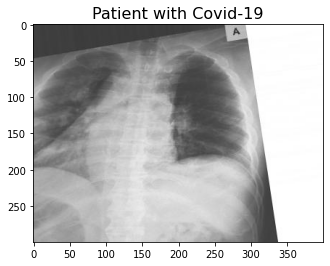

In [15]:
covid = cv2.imread("/content/gdrive/My Drive/Kaggle/TrainData/COVID-19/_0_1465610.jpeg")
plt.rcParams["axes.grid"] = False
plt.rcParams["axes.titlesize"] = 16
plt.title("Patient with Covid-19")
plt.imshow(covid);

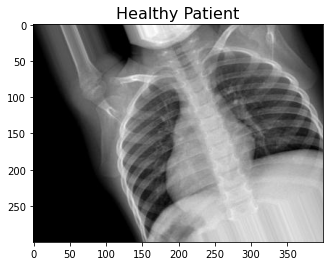

In [17]:
Normal = cv2.imread("/content/gdrive/My Drive/Kaggle/TrainData/Normal/_0_6256933.jpeg")
plt.rcParams["axes.grid"] = False
plt.rcParams["axes.titlesize"] = 16
plt.title("Healthy Patient")
plt.imshow(Normal);

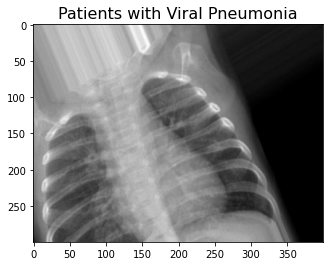

In [19]:
viral = cv2.imread("/content/gdrive/My Drive/Kaggle/TrainData/ViralPneumonia/_0_9503218.jpeg")
plt.rcParams["axes.grid"] = False
plt.rcParams["axes.titlesize"] = 16
plt.title("Patients with Viral Pneumonia")
plt.imshow(viral);

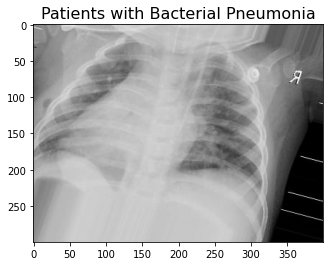

In [20]:
bacterial = cv2.imread("/content/gdrive/My Drive/Kaggle/TrainData/BacterialPneumonia/_0_4754176.jpeg")
plt.rcParams["axes.grid"] = False
plt.rcParams["axes.titlesize"] = 16
plt.title("Patients with Bacterial Pneumonia")
plt.imshow(bacterial);

When building the Convolutional Neural Network, the Sequential function was used, which allows the construction of linear stacked layers, being possible to treat each layer as an object that feeds data to the next one. 
The first layer is always convolutional. The input size consists at 384x384x3 array of pixel values, where 3 is RGB-related and this feature map is passed through an activation layer, ReLU. 
Then the building of the pooling layer starts. This layer consists in reducing the dimensionality of each feature map by retaining the most important information.
Finally, we flatten the feature map into 1D, to be introduced in a Fully Connected Layer with a final output that has 4 neurons which is the number of classes. 

-----

The following models were subjected to different parameters upon construction, furthermore we also used different methods for overfitting prevention.

## First Model

In [21]:
model1 = Sequential()

model1.add(Conv2D(16, (3,3), input_shape=(384,384,3), activation = "relu"))
model1.add(Conv2D(32, (3,3), activation = "relu"))
model1.add(Conv2D(64, (3,3), activation = "relu"))

model1.add(MaxPool2D(2,2))
model1.add(MaxPool2D(2,2))
model1.add(MaxPool2D(2,2))

model1.add(Flatten())
model1.add(Dropout(0.5))
model1.add(Dense(64, activation = "relu"))
model1.add(Dense(4, activation = "softmax"))
model1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 382, 382, 16)      448       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 380, 380, 32)      4640      
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 378, 378, 64)      18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 189, 189, 64)      0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 94, 94, 64)        0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 47, 47, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 141376)           

The learning process can then be figured using the compile method where our loss is defined as categorical cross-entropy. We will then use our optimizer- rmsprop, which will perform the gradient descent. And finally, a list of metrics, set to accuracy as this is a classification problem.

In [22]:
model1.compile(loss = 'categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

Now, we write out our fit function to train the model, giving it parameters for the training and validation data and the number of epochs to run for each. 

In [23]:
history1 = model1.fit(train_generator, validation_data = test_generator, steps_per_epoch=64, epochs = 40,  verbose = 1)

Epoch 1/40
64/64 [==============================] - 989s 15s/step - loss: 1.9952 - accuracy: 0.3922 - val_loss: 0.9946 - val_accuracy: 0.5283
Epoch 2/40
64/64 [==============================] - 94s 1s/step - loss: 1.0783 - accuracy: 0.5751 - val_loss: 0.8951 - val_accuracy: 0.6265
Epoch 3/40
64/64 [==============================] - 94s 1s/step - loss: 0.9221 - accuracy: 0.6227 - val_loss: 1.0133 - val_accuracy: 0.5182
Epoch 4/40
64/64 [==============================] - 94s 1s/step - loss: 0.8350 - accuracy: 0.6652 - val_loss: 0.7499 - val_accuracy: 0.7085
Epoch 5/40
64/64 [==============================] - 94s 1s/step - loss: 0.7958 - accuracy: 0.6827 - val_loss: 0.7771 - val_accuracy: 0.6852
Epoch 6/40
64/64 [==============================] - 94s 1s/step - loss: 0.7525 - accuracy: 0.6896 - val_loss: 0.8019 - val_accuracy: 0.6549
Epoch 7/40
64/64 [==============================] - 94s 1s/step - loss: 0.7487 - accuracy: 0.6971 - val_loss: 2.0715 - val_accuracy: 0.5172
Epoch 8/40
64/64 [

#### Visualization of learning curves

In [40]:
history1_df = pd.DataFrame(history1.history)

print(("Best Validation Loss: {:0.4f}" +\
      "\nBest Validation Accuracy: {:0.4f}")\
      .format(history1_df['val_loss'].min(), 
              history1_df['val_accuracy'].max()))

Best Validation Loss: 0.7070
Best Validation Accuracy: 0.7409


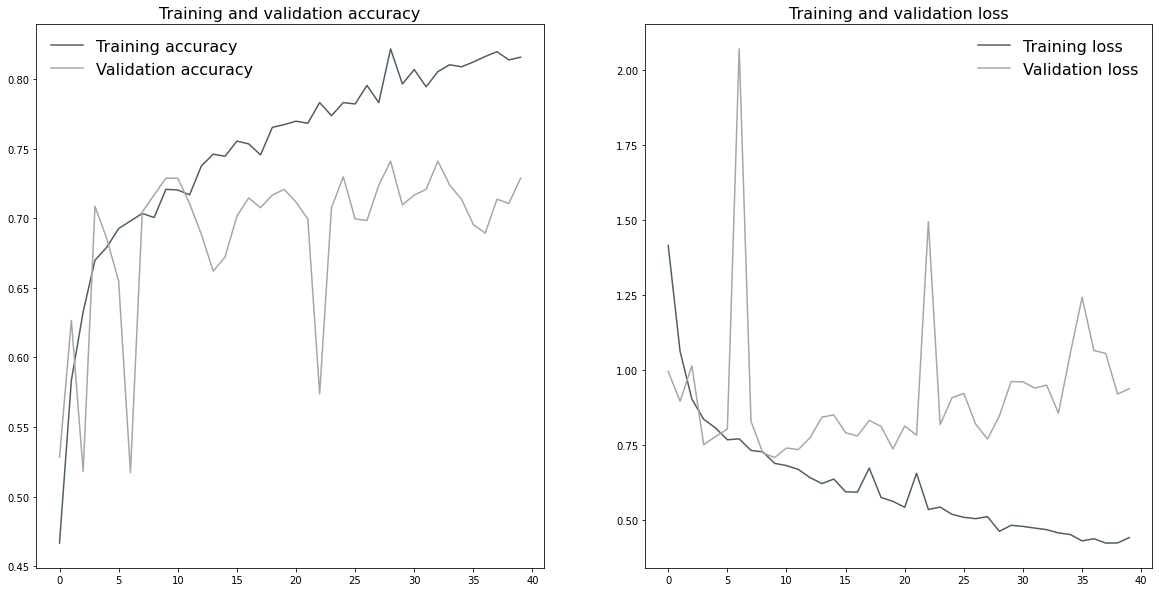

<Figure size 432x288 with 0 Axes>

In [78]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
epochs = range(len(history1.history['accuracy']))
ax1.plot(epochs, history1.history['accuracy'], '#4C5E66', label='Training accuracy')
ax1.plot(epochs, history1.history['val_accuracy'], '#A6A6A6', label='Validation accuracy')
ax1.set_title('Training and validation accuracy')
ax1.legend(frameon=False, fontsize=16)

ax2.plot(epochs, history1.history['loss'], '#4C5E66', label='Training loss')
ax2.plot(epochs, history1.history['val_loss'], '#A6A6A6', label='Validation loss')
ax2.set_title('Training and validation loss')
ax2.legend(frameon=False, fontsize=16)
           
plt.show()
plt.savefig(os.path.join('model1.png'), dpi=300, format='png', bbox_inches='tight')

#### Building Confusion Matrix


In [56]:
Y_preds=model1.predict_generator(test_generator)
y_pred = np.argmax(Y_preds, axis=1)
Matrix1 = confusion_matrix(test_generator.classes, y_pred)
print('Confusion Matrix')
print(Matrix1)
print('Classification Report')
target_names = ['BacterialPneumonia', 'COVID-19', 'Normal', 'ViralPneumonia']
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

Confusion Matrix
[[108   1 182  33]
 [  5   0   3   1]
 [149   2 262  37]
 [ 63   1 113  28]]
Classification Report
                    precision    recall  f1-score   support

BacterialPneumonia       0.33      0.33      0.33       324
          COVID-19       0.00      0.00      0.00         9
            Normal       0.47      0.58      0.52       450
    ViralPneumonia       0.28      0.14      0.18       205

          accuracy                           0.40       988
         macro avg       0.27      0.26      0.26       988
      weighted avg       0.38      0.40      0.38       988



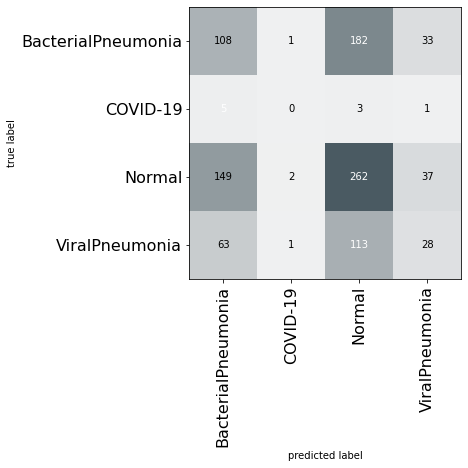

<Figure size 432x288 with 0 Axes>

In [77]:
cmap = sns.light_palette("#4A5A62", as_cmap=True)
plot_confusion_matrix(Matrix1 ,figsize=(10,5), hide_ticks=True,cmap=cmap)
plt.xticks(range(4), ['BacterialPneumonia', 'COVID-19', 'Normal', 'ViralPneumonia'], fontsize=16, rotation=90)
plt.yticks(range(4), ['BacterialPneumonia', 'COVID-19', 'Normal', 'ViralPneumonia'], fontsize=16)
plt.show()
plt.savefig(os.path.join('cm1.png'), dpi=300, format='png', bbox_inches='tight')

## Second Model

In [42]:
early_stopping = callbacks.EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=20, # how many epochs to wait before stopping
    restore_best_weights=True,
)

In [43]:
model2 = Sequential()

model2.add(Conv2D(16, (3,3), input_shape=(384,384,3), activation = "relu"))
model2.add(Conv2D(32, (3,3), activation = "relu"))
model2.add(Conv2D(64, (3,3), activation = "relu"))

model2.add(MaxPool2D(2,2))
model2.add(MaxPool2D(2,2))
model2.add(MaxPool2D(2,2))

model2.add(Flatten())
model2.add(Dropout(0.5))
model2.add(Dense(250, activation = "relu"))
model2.add(Dense(4, activation = "softmax"))
model2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 382, 382, 16)      448       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 380, 380, 32)      4640      
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 378, 378, 64)      18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 189, 189, 64)      0         
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 94, 94, 64)        0         
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 47, 47, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 141376)           

In [44]:
model2.compile(loss = 'categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [45]:
history2 = model2.fit(train_generator, validation_data = test_generator, steps_per_epoch=64,epochs = 40, callbacks=[early_stopping], verbose = 1) 

Epoch 1/40
64/64 [==============================] - 95s 1s/step - loss: 2.9894 - accuracy: 0.4282 - val_loss: 1.0232 - val_accuracy: 0.5223
Epoch 2/40
64/64 [==============================] - 93s 1s/step - loss: 1.0844 - accuracy: 0.5829 - val_loss: 1.0959 - val_accuracy: 0.5587
Epoch 3/40
64/64 [==============================] - 93s 1s/step - loss: 0.9511 - accuracy: 0.6052 - val_loss: 1.0616 - val_accuracy: 0.5395
Epoch 4/40
64/64 [==============================] - 92s 1s/step - loss: 0.8586 - accuracy: 0.6511 - val_loss: 0.9023 - val_accuracy: 0.6144
Epoch 5/40
64/64 [==============================] - 92s 1s/step - loss: 0.8129 - accuracy: 0.6641 - val_loss: 0.8143 - val_accuracy: 0.6366
Epoch 6/40
64/64 [==============================] - 93s 1s/step - loss: 0.7966 - accuracy: 0.6829 - val_loss: 0.8531 - val_accuracy: 0.6781
Epoch 7/40
64/64 [==============================] - 92s 1s/step - loss: 0.7361 - accuracy: 0.7008 - val_loss: 0.7554 - val_accuracy: 0.6953
Epoch 8/40
64/64 [==

#### Visualization of learning curves

In [63]:
history2_df = pd.DataFrame(history2.history)

print(("Best Validation Loss: {:0.4f}" +\
      "\nBest Validation Accuracy: {:0.4f}")\
      .format(history2_df['val_loss'].min(), 
              history2_df['val_accuracy'].max()))

Best Validation Loss: 0.6988
Best Validation Accuracy: 0.7358


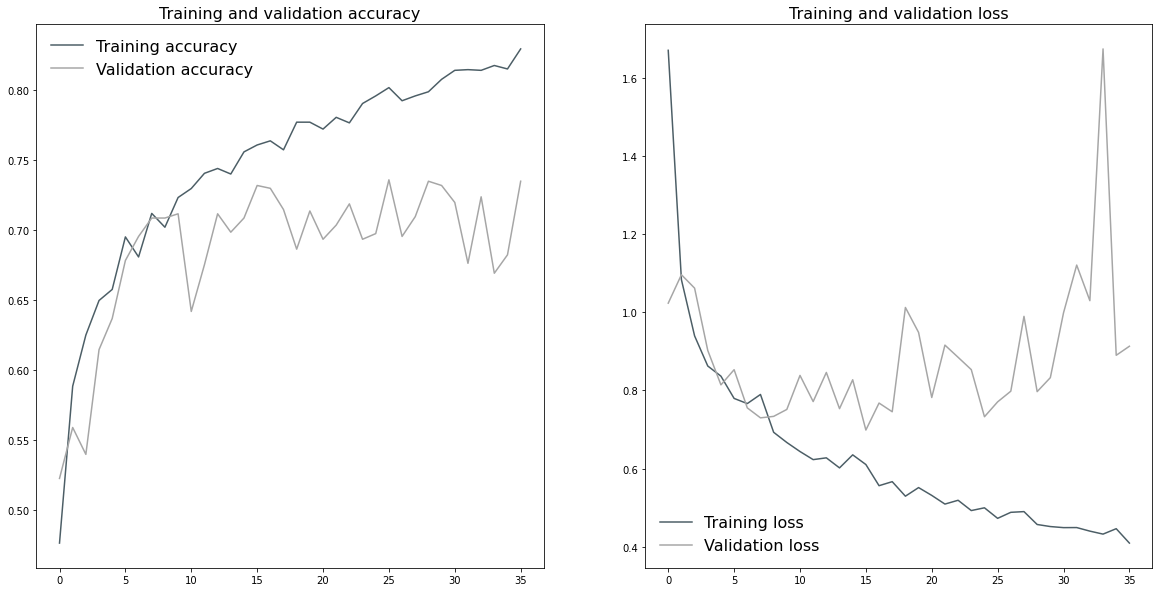

<Figure size 432x288 with 0 Axes>

In [76]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
epochs = range(len(history2.history['accuracy']))
ax1.plot(epochs, history2.history['accuracy'], '#4C5E66', label='Training accuracy')
ax1.plot(epochs, history2.history['val_accuracy'], '#A6A6A6', label='Validation accuracy')
ax1.set_title('Training and validation accuracy')
ax1.legend(frameon=False, fontsize=16)

ax2.plot(epochs, history2.history['loss'], '#4C5E66', label='Training loss')
ax2.plot(epochs, history2.history['val_loss'], '#A6A6A6', label='Validation loss')
ax2.set_title('Training and validation loss')
ax2.legend(frameon=False, fontsize=16)
           
plt.show()
plt.savefig(os.path.join('model2.png'), dpi=300, format='png', bbox_inches='tight')

#### Building Confusion Matrix

In [65]:
Y_preds=model2.predict_generator(test_generator)
y_pred = np.argmax(Y_preds, axis=1)
Matrix2 = confusion_matrix(test_generator.classes, y_pred)
print('Confusion Matrix')
print(Matrix2)
print('Classification Report')
target_names = ['BacterialPneumonia', 'COVID-19', 'Normal', 'ViralPneumonia']
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

Confusion Matrix
[[125   1 180  18]
 [  2   0   7   0]
 [176   3 241  30]
 [ 67   3 123  12]]
Classification Report
                    precision    recall  f1-score   support

BacterialPneumonia       0.34      0.39      0.36       324
          COVID-19       0.00      0.00      0.00         9
            Normal       0.44      0.54      0.48       450
    ViralPneumonia       0.20      0.06      0.09       205

          accuracy                           0.38       988
         macro avg       0.24      0.24      0.23       988
      weighted avg       0.35      0.38      0.36       988



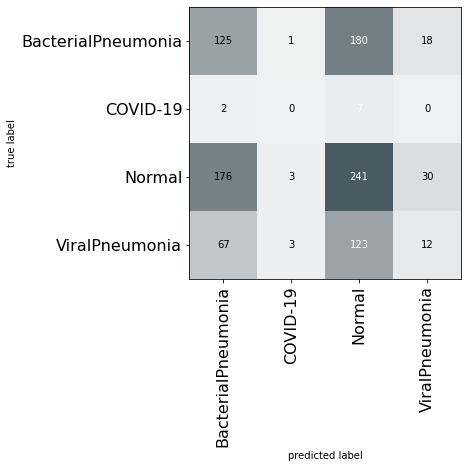

<Figure size 432x288 with 0 Axes>

In [75]:
cmap = sns.light_palette("#4A5A62", as_cmap=True)
plot_confusion_matrix(Matrix2 ,figsize=(10,5), hide_ticks=True,cmap=cmap)
plt.xticks(range(4), ['BacterialPneumonia', 'COVID-19', 'Normal', 'ViralPneumonia'], fontsize=16, rotation=90)
plt.yticks(range(4), ['BacterialPneumonia', 'COVID-19', 'Normal', 'ViralPneumonia'], fontsize=16)
plt.show()
plt.savefig(os.path.join('cm2.png'), dpi=300, format='png', bbox_inches='tight')

## Third Model

In [67]:
model3 = Sequential()

model3.add(Conv2D(16, (3,3), input_shape=(384,384,3), activation = "relu",  kernel_regularizer=l2(0.001)))
model3.add(Conv2D(32, (3,3), activation = "relu", kernel_regularizer=l2(0.001)))
model3.add(Conv2D(64, (3,3), activation = "relu", kernel_regularizer=l2(0.001)))

model3.add(MaxPool2D(2,2))
model3.add(MaxPool2D(2,2))
model3.add(MaxPool2D(2,2))

model3.add(Flatten())
model3.add(Dropout(0.5))
model3.add(Dense(64, activation = "relu"))
model3.add(Dense(4, activation = "softmax"))
model3.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 382, 382, 16)      448       
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 380, 380, 32)      4640      
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 378, 378, 64)      18496     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 189, 189, 64)      0         
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 94, 94, 64)        0         
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 47, 47, 64)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 141376)           

In [68]:
model3.compile(loss = 'categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [70]:
history3 = model3.fit(train_generator, validation_data = test_generator, steps_per_epoch=64,epochs = 40, verbose = 1) 

Epoch 1/40
64/64 [==============================] - 93s 1s/step - loss: 3.6428 - accuracy: 0.4391 - val_loss: 1.1165 - val_accuracy: 0.4696
Epoch 2/40
64/64 [==============================] - 91s 1s/step - loss: 1.1292 - accuracy: 0.5817 - val_loss: 1.0922 - val_accuracy: 0.5334
Epoch 3/40
64/64 [==============================] - 92s 1s/step - loss: 0.9969 - accuracy: 0.6148 - val_loss: 1.1193 - val_accuracy: 0.4727
Epoch 4/40
64/64 [==============================] - 91s 1s/step - loss: 0.9885 - accuracy: 0.6278 - val_loss: 1.0253 - val_accuracy: 0.5617
Epoch 5/40
64/64 [==============================] - 91s 1s/step - loss: 0.8945 - accuracy: 0.6555 - val_loss: 1.0734 - val_accuracy: 0.4636
Epoch 6/40
64/64 [==============================] - 90s 1s/step - loss: 0.8435 - accuracy: 0.6768 - val_loss: 0.8951 - val_accuracy: 0.6387
Epoch 7/40
64/64 [==============================] - 90s 1s/step - loss: 0.7765 - accuracy: 0.6908 - val_loss: 1.1054 - val_accuracy: 0.3796
Epoch 8/40
64/64 [==

#### Visualization of learning curves

In [71]:
history3_df = pd.DataFrame(history3.history)

print(("Best Validation Loss: {:0.4f}" +\
      "\nBest Validation Accuracy: {:0.4f}")\
      .format(history3_df['val_loss'].min(), 
              history3_df['val_accuracy'].max()))

Best Validation Loss: 0.7289
Best Validation Accuracy: 0.7561


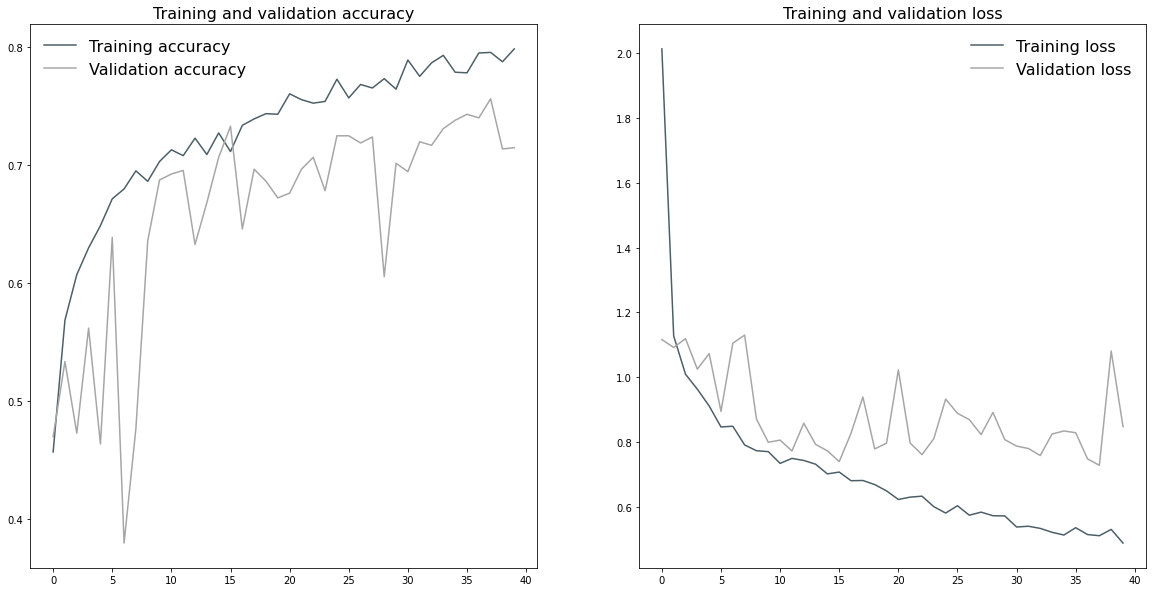

<Figure size 432x288 with 0 Axes>

In [72]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
epochs = range(len(history3.history['accuracy']))
ax1.plot(epochs, history3.history['accuracy'], '#4C5E66', label='Training accuracy')
ax1.plot(epochs, history3.history['val_accuracy'], '#A6A6A6', label='Validation accuracy')
ax1.set_title('Training and validation accuracy')
ax1.legend(frameon=False, fontsize=16)

ax2.plot(epochs, history3.history['loss'], '#4C5E66', label='Training loss')
ax2.plot(epochs, history3.history['val_loss'], '#A6A6A6', label='Validation loss')
ax2.set_title('Training and validation loss')
ax2.legend(frameon=False, fontsize=16)
           
plt.show()
plt.savefig(os.path.join('model3.png'), dpi=300, format='png', bbox_inches='tight')

In [73]:
Y_preds=model3.predict_generator(test_generator)
y_pred = np.argmax(Y_preds, axis=1)
Matrix3 = confusion_matrix(test_generator.classes, y_pred)
print('Confusion Matrix')
print(Matrix)
print('Classification Report')
target_names = ['BacterialPneumonia', 'COVID-19', 'Normal', 'ViralPneumonia']
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

Confusion Matrix
[[110   1 186  27]
 [  1   0   5   3]
 [142   2 262  44]
 [ 72   1 107  25]]
Classification Report
                    precision    recall  f1-score   support

BacterialPneumonia       0.31      0.31      0.31       324
          COVID-19       0.00      0.00      0.00         9
            Normal       0.46      0.59      0.52       450
    ViralPneumonia       0.29      0.11      0.16       205

          accuracy                           0.39       988
         macro avg       0.26      0.25      0.25       988
      weighted avg       0.37      0.39      0.37       988



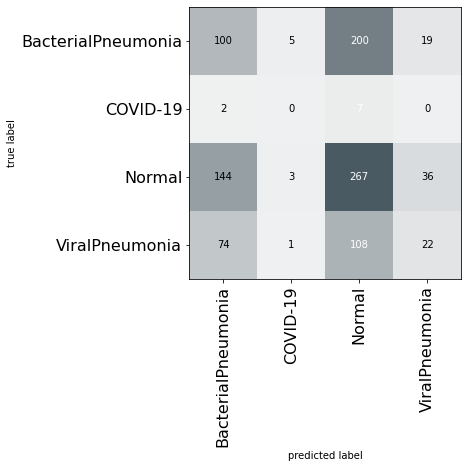

<Figure size 432x288 with 0 Axes>

In [74]:
cmap = sns.light_palette("#4A5A62", as_cmap=True)
plot_confusion_matrix(Matrix3 ,figsize=(10,5), hide_ticks=True,cmap=cmap)
plt.xticks(range(4), ['BacterialPneumonia', 'COVID-19', 'Normal', 'ViralPneumonia'], fontsize=16, rotation = 90)
plt.yticks(range(4), ['BacterialPneumonia', 'COVID-19', 'Normal', 'ViralPneumonia'], fontsize=16)
plt.show()
plt.savefig(os.path.join('cm3.png'), dpi=300, format='png', bbox_inches='tight')